# Equity Market Crisis Regime Prediction using Machine Learning GBDT

## Part V: Model Evaluation and Interpretation (LightGBM)

### Quick access to the whole series:

1. [Part I: Introduction](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt1)
1. [Part II: Data Preparation](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt2)
1. [Part III: Exploratory data analysis](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt3)
1. [Part IV: Feature Selection, Hyperparameter Tuning (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt4)
1. [Part V: Model Evaluation and Interpretation (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt5)
1. [Part VI: SVM and Neural Networks (MLP and 1D-CNN)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt6)
1. [Part VII: Compare GBDT Models: XGBoost and LightGBM](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt7)
1. [Part VIII: Deployment: end-to-end process (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt8)

---



### Outline of this notebook

<a id="toc"></a>

- [1. Load data](#1)
    
    
- [2. 5-fold of Expanding Window](#2)
    - [2.1 Create expanding window data folds](#2.1)
    - [2.2 Predict testing data with models trained on train data](#2.2)
    - [2.3 Model performance - Ground truth and Predictions](#2.3)
    - [2.4 Model performance - AUC and Confusion matrix](#2.4)
    
    

- [3. Sliding Window with Fixed Length of Training Data](#3)
    - [3.1 Create Sliding window - fixed length of training data](#3.1)
    - [3.2 Predict testing data with models trained on train data](#3.2)
    - [3.3 Model performance - Ground truth and Predictions](#3.3)
    - [3.4 Model performance - AUC and Confusion matrix](#3.4)
    
    

- [4. Model Interpretation and Explanation with SHAP](#4)
    - [4.1 SHAP (SHapley Additive exPlanations)](#4.1)
    - [4.2 True Positive Example: Model correctly predicted imminent crisis regime](#4.2)
    - [4.3 True Negative Example: Model correctly predicted normal regime](#4.3)
    - [4.4 Visualize the Trees](#4.4)




## Load and install packages

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import copy
import json
from pathlib import Path
from datetime import datetime, timedelta, date
import time
from dateutil.relativedelta import relativedelta 


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import statsmodels.api as sm
import seaborn as sns


import pyarrow.parquet as pq
import pyarrow as pa

from tqdm import tqdm


In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
random_seed=1
pl.seed_everything(random_seed)

1

<a id="1"></a>

# <left>1. Load data</left>

[back to top](#toc)

In [3]:
df = pd.read_parquet('../input/equity-market-crisis-regime-prediction-using-gbdt2/data.parquet')
df.set_index(keys=['x_date'], inplace=True)

In [4]:
target_cols = ['pct_chg15', 'regime_change', 'target']
feats = set(df.columns)-set(target_cols)

In [5]:
#final_feats = ['T1YFF_pct_chg60', 'LRUN64TTJPM156S_pct_chg250', 'AAA10Y_chg10', 'T10Y2Y_pct_chg10', 'STOXX50E_chg10', 'BAMLHE00EHYITRIV_pct_chg10', 'T10YFFM_pct_chg10', 'STLFSI3_chg10', 'VIX_chg10', 'JPY=X_pct_chg10', 'IRLTLT01JPM156N_ma_dist20_50', 'NASDAQ100_zscore60', 'KS11_pct_chg10', 'CL=F_pct_chg10', 'T1YFF_pct_chg10', 'CFNAIMA3_ma_dist20_50', 'BAAFFM_zscore60', 'T10Y2YM_zscore250', 'DJI_ma_dist20_50', 'NFCI_zscore60', 'WILLREITIND_zscore60', 'NIKKEI225_zscore60', 'TENEXPCHAREARISPRE_chg250', 'JTSOSL_zscore60', 'CPFF_pct_chg250', 'VIX_pct_chg60', 'COMPOUT_ma_dist20_50', 'STLFSI3_pct_chg10', 'IXIC_ma_dist20_50', 'WILLREITIND_chg10', 'KLSE_zscore60', 'VXDCLS_chg250', 'STLFSI3_zscore250', 'RUT_zscore60', 'LRUN64TTJPM156S_ma_dist20_50', 'UMCSENT_zscore60', 'TENEXPCHAREARISPRE_zscore60', 'GC=F_zscore60', 'JTSOSL_ma_dist20_50', 'RVXCLS_chg10', 'VIXCLS_zscore60', 'NFCIRISK_zscore60', 'T5YIE_pct_chg10', 'AAAFF_pct_chg10', 'T10YFF_pct_chg60', 'ANFCI_pct_chg10', 'ABCOMP_ma_dist20_50', 'IRLTLT01JPM156N_ma_dist200_50', 'VXNCLS_chg10', 'T1YFF_chg10', 'T10Y2Y_chg10', 'NFCIRISK_pct_chg60', 'MANMM101JPM189S_zscore60', 'STLPPMDEF_zscore60', 'CPFF_pct_chg60', 'STLPPM_ma_dist20_50', 'NFCICREDIT_pct_chg10', 'RBJPBIS_chg10', 'JTSOSL_zscore250', 'NFCICREDIT_chg10', 'IRSTCI01JPM156N_zscore60', 'KS11_pct_chg60', 'CFNAI_zscore60', 'T10YIEM_chg60', 'ANFCI_zscore60', 'MYAGM2JPM189S_ma_dist200_50', 'T10Y2YM_pct_chg250', 'KLSE_ma_dist20_50', 'CFNAIDIFF_ma_dist20_50', 'BAMLHYH0A3CMTRIV_pct_chg10', 'KS11_ma_dist20_50', 'BAMLCC0A1AAATRIV_zscore60', 'GC=F_pct_chg10', 'VXNCLS_zscore250', 'STLFSI3_pct_chg60', 'T10YIEM_pct_chg60', 'N100_zscore250', 'TYX_ma_dist200_50', 'NFCI_pct_chg10', 'NASDAQCOM_pct_chg10', 'PAYNSA_chg60', 'IRX_chg10', 'CFNAI_ma_dist20_50', 'CL=F_zscore60', 'BAAFFM_ma_dist200_50', 'T3MFF_zscore60', 'MICH_ma_dist20_50', 'STLFSI3_zscore60', 'GC=F_chg10', 'WILLREITIND_ma_dist20_50', 'NFCICREDIT_pct_chg60', 'KLSE_pct_chg10', 'PAYNSA_ma_dist20_50', 'RBJPBIS_zscore60', 'HSI_chg10', 'AAAFF_chg10', 'STLPPMDEF_chg250', 'FVX_pct_chg10', 'FTSE_chg10', 'N225_chg10', 'BAMLHYH0A0HYM2TRIV_chg10', 'JPNASSETS_zscore60', 'JPNCPIALLMINMEI_pct_chg10', 'CPFF_pct_chg10', 'VIX_zscore60', 'BAA10YM_zscore250', 'ABCOMP_zscore60', 'T10Y3M_pct_chg250', 'PAYEMS_zscore250', 'T10Y2YM_chg250', 'NFCILEVERAGE_chg10', 'NFCINONFINLEVERAGE_zscore60', 'HSI_zscore60', 'VXDCLS_pct_chg10', 'JPNCPIALLMINMEI_zscore60', 'DJI_pct_chg10', 'T3MFF_chg10', 'WILLLRGCAPGR_chg10', 'MYAGM2JPM189S_zscore60', 'FVX_ma_dist20_50', 'VXNCLS', 'NFCICREDIT', 'NFCIRISK_chg10', 'FTSE_zscore60']
#final_feats = ['BAAFFM_ma_dist200_50', 'HSI_chg20', 'PAYEMS_chg60', 'RBJPBIS_ma_dist20_50', 'WILLSMLCAP_chg20', 'BAMLHE00EHYITRIV_pct_chg5', 'WILLREITIND_pct_chg20', 'EXPINF1YR_chg5_above200dMA', 'GVZCLS_chg5', 'TENEXPCHAINFRISPRE_ma_dist20_50', 'AAA10Y_pct_chg5', 'N225_pct_chg20', 'RUT_chg10', 'BAAFFM_zscore250', 'BAMLHYH0A0HYM2TRIV_pct_chg10', 'OVXCLS_volat60', 'PAYNSA_std60', 'GC=F_pct_chg10', 'T10Y2Y_pct_chg120', 'KCFSI_chg20', 'CPFF_chg5', 'T10YIEM_chg60', 'CPFF_pct_chg10', 'HSI_chg5', 'FVX_pct_chg10', 'KS11_pct_chg5', 'NIKKEI225_std60_chg200', 'IRSTCI01JPM156N_chg20', 'DX-Y.NYB_zscore60', 'BAMLHYH0A3CMTRIV_chg10', 'WILLLRGCAPVAL_zscore60', 'N100_std60_chg200', 'TNX_chg20', 'T5YFF_chg10', 'GC=F_chg20', 'VXDCLS_pct_chg20', 'LFWA64TTJPM647S_chg60', 'ABCOMP_pct_chg5', 'HSI_zscore60', 'MYAGM2JPM189S_zscore120', 'USSLIND_pct_chg20', 'T10YFFM_zscore60', 'VXNCLS_chg5', 'STLFSI3_pct_chg60', 'NIKKEI225_zscore120', 'GC=F_chg10', 'STLPPM_chg5', 'VXDCLS_chg5', 'T10Y3M_pct_chg250', 'BAA10Y_zscore250', 'FTSE_chg120', 'NASDAQCOM_zscore60', 'NFCI_pct_chg10', 'ABCOMP_chg5', 'NFCICREDIT_pct_chg5', 'VIX_zscore60', 'VXNCLS_pct_chg10', 'NDX_std125', 'T3MFF_chg10', 'FVX_zscore200', 'WILLREITIND_chg20', 'T10YIEM_pct_chg60', 'FVX_pct_chg5', 'STLFSI3_chg5', 'HSI_chg10', 'NDX_pct_chg10', 'FTSE_chg20', 'WILLLRGCAPGR_chg10', 'CPFF_pct_chg20', 'REAINTRATREARAT1MO_ma_dist500_250', 'MYAGM2JPM189S_chg5', 'VIX_chg10', 'FTSE_pct_chg10', 'T10YFF_pct_chg20', 'NFCILEVERAGE_chg250', 'NFCI_chg5', 'T10Y2YM_chg250', 'FVX_ma_dist20_50', 'N100_chg10', 'T10Y2YM_std125_chg200', 'CFNAIDIFF_std60', 'DJI_zscore120', 'NFCICREDIT_std60', 'DJI_chg10', 'DJI_pct_chg20', 'FTSE_zscore60', 'WILLLRGCAPVAL_pct_chg10', 'N100_zscore200']
#vif threshold = 20
#final_feats = ['NASDAQ100_std125_chg200', 'MICH_ma_dist20_50', 'STLPPM_ma_dist20_50', 'GC=F_chg5', 'STLFSI3_pct_chg5', 'VIXCLS_chg20', 'VIX_zscore250', 'IRLTLT01JPM156N_std125', 'LFWA64TTJPM647S_volat60', 'WILLLRGCAPVAL_std60_chg200', 'GC=F_pct_chg20_above200dMA', 'PAYNSA_zscore200', 'T1YFF_pct_chg20', 'NIKKEI225_zscore120', 'LRUN64TTJPM156S_std125_chg200', 'MYAGM2JPM189S_zscore60', 'T1YFF_ma_dist200_50', 'WILLSMLCAP_chg20', 'HSI_chg5', 'BAAFFM_ma_dist200_50', 'JPNASSETS_zscore120', 'NIKKEI225_std60_chg200', 'HSI_chg20', 'N225_pct_chg20', 'FVX_chg5', 'NASDAQ100_pct_chg10', 'BAA10Y_mean_std250', 'RBJPBIS_ma_dist20_50', 'KS11_pct_chg5', 'WILLSMLCAP_chg10', 'GSPC_mean_std120', 'T10Y2Y_pct_chg120', 'JTSOSL_std60_chg200', 'BAMLHYH0A0HYM2TRIV_std125_chg200', 'IRLTLT01JPM156N_std60_chg200', 'TB3SMFFM_zscore200', 'NIKKEI225_pct_chg10', 'RBJPBIS_zscore60', 'WILLREITIND_ma_dist20_50', 'LRUN64TTJPM156S_pct_chg250', 'MICH_pct_chg5', 'TNX_mean_std120', 'MABMM301JPM189S_mean_std120', 'BAMLHE00EHYITRIV_chg10', 'VXNCLS_mean_std120', 'MYAGM2JPM189S_std125', 'BAA10YM_zscore120', 'T10Y3M_chg250', 'MYAGM2JPM189S_chg20', 'EXPINF1YR_chg5_above200dMA', 'NFCICREDIT_pct_chg60', 'GC=F_pct_chg10', 'GC=F_pct_chg20', 'REAINTRATREARAT1YE_pct_chg120', 'NDX_chg120', 'GVZCLS_chg5', 'BAMLHE00EHYITRIV_pct_chg5', 'KCFSI_chg20', 'AAA10Y_pct_chg5', 'TENEXPCHAINFRISPRE_ma_dist20_50', 'T3MFF_zscore120', 'PAYNSA_std60', 'T5YIEM_pct_chg20', 'BAMLHE00EHYITRIV_chg5', 'USSLIND_pct_chg120', 'FVX_pct_chg10', 'BAMLHE00EHYITRIV_chg120', 'T10YIEM_chg60', 'WILLREITIND_pct_chg20', 'BAA10Y_pct_chg10', 'T10YFF_chg10', 'LFWA64TTJPM647S_chg60', 'OVXCLS_volat60', 'LFWA64TTJPM647S_zscore200', 'RUT_pct_chg10', 'PAYEMS_zscore200', 'VXNCLS_chg10', 'BAA10Y_zscore250', 'NDX_chg10', 'T10Y2YM_zscore250', 'JPNASSETS', 'CPFF_pct_chg10', 'WILLREITIND_chg20', 'TNX_chg20', 'IRSTCI01JPM156N_chg20', 'GC=F_zscore60', 'WILLLRGCAPGR_zscore60', 'CPFF_pct_chg250', 'CPFF_chg5', 'BAMLHYH0A3CMTRIV_chg10', 'CPFF_pct_chg5', 'GC=F_chg10', 'VXNCLS_chg5', 'GC=F_chg20', 'FVX_pct_chg5', 'T10Y2Y_pct_chg250', 'FTSE_chg10', 'N100_std60_chg200', 'HSI_zscore60', 'NFCIRISK_pct_chg60', 'STLFSI3_pct_chg60', 'VIX_pct_chg10', 'RVXCLS_chg10', 'NFCICREDIT_pct_chg5', 'STLPPM_chg5', 'T3MFF_zscore60', 'ABCOMP_chg5', 'T10Y3M_pct_chg250', 'ABCOMP_pct_chg5', 'USSLIND_pct_chg20', 'STLPPM_pct_chg5', 'T3MFF_chg10', 'FVX_zscore200', 'VXDCLS_chg5', 'VIX_zscore60', 'VIX_chg20', 'STOXX50E_pct_chg10', 'DJI_zscore120', 'NDX_pct_chg10', 'STLFSI3_chg5', 'NFCICREDIT', 'BAAFFM_zscore250', 'VIX_chg10', 'T10YIEM_pct_chg60', 'NDX_zscore60', 'HSI_chg10', 'AAAFF_pct_chg5', 'FTSE_mean_std120', 'MYAGM2JPM189S_chg5', 'BAMLHE00EHYITRIV_pct_chg250', 'REAINTRATREARAT1MO_ma_dist500_250', 'CPFF_pct_chg20', 'VXDCLS_pct_chg10', 'BAMLHYH0A3CMTRIV_zscore120', 'T10Y2YM_chg250', 'NFCI_chg5', 'N100_chg10', 'FTSE_chg20', 'FVX_ma_dist20_50', 'T10YFF_pct_chg20', 'N100_chg20', 'NFCILEVERAGE_chg250', 'BAMLHYH0A0HYM2TRIV_pct_chg10', 'NFCICREDIT_std60', 'T10Y2YM_std125_chg200', 'NFCICREDIT_chg5', 'CFNAIDIFF_std60', 'N100_zscore120', 'WILLLRGCAPVAL_chg10', 'DJI_pct_chg20', 'FTSE_zscore60', 'DJI_chg10']
#vif threshold = 10
final_feats = ['NASDAQ100_std125_chg200', 'MICH_ma_dist20_50', 'STLPPM_ma_dist20_50', 'GC=F_chg5', 'STLFSI3_pct_chg5', 'VIXCLS_chg20', 'VIX_zscore250', 'IRLTLT01JPM156N_std125', 'LFWA64TTJPM647S_volat60', 'WILLLRGCAPVAL_std60_chg200', 'GC=F_pct_chg20_above200dMA', 'PAYNSA_zscore200', 'T1YFF_pct_chg20', 'NIKKEI225_zscore120', 'LRUN64TTJPM156S_std125_chg200', 'T1YFF_ma_dist200_50', 'WILLSMLCAP_chg20', 'HSI_chg5', 'JPNASSETS_zscore120', 'NIKKEI225_std60_chg200', 'HSI_chg20', 'N225_pct_chg20', 'FVX_chg5', 'NASDAQ100_pct_chg10', 'RBJPBIS_ma_dist20_50', 'KS11_pct_chg5', 'WILLSMLCAP_chg10', 'T10Y2Y_pct_chg120', 'JTSOSL_std60_chg200', 'BAMLHYH0A0HYM2TRIV_std125_chg200', 'IRLTLT01JPM156N_std60_chg200', 'TB3SMFFM_zscore200', 'NIKKEI225_pct_chg10', 'RBJPBIS_zscore60', 'WILLREITIND_ma_dist20_50', 'LRUN64TTJPM156S_pct_chg250', 'MICH_pct_chg5', 'TNX_mean_std120', 'BAMLHE00EHYITRIV_chg10', 'VXNCLS_mean_std120', 'MYAGM2JPM189S_std125', 'BAA10YM_zscore120', 'T10Y3M_chg250', 'MYAGM2JPM189S_chg20', 'EXPINF1YR_chg5_above200dMA', 'NFCICREDIT_pct_chg60', 'GC=F_pct_chg10', 'REAINTRATREARAT1YE_pct_chg120', 'NDX_chg120', 'GVZCLS_chg5', 'KCFSI_chg20', 'AAA10Y_pct_chg5', 'TENEXPCHAINFRISPRE_ma_dist20_50', 'T5YIEM_pct_chg20', 'BAMLHE00EHYITRIV_chg5', 'USSLIND_pct_chg120', 'FVX_pct_chg10', 'T10YIEM_chg60', 'WILLREITIND_pct_chg20', 'BAA10Y_pct_chg10', 'T10YFF_chg10', 'LFWA64TTJPM647S_chg60', 'OVXCLS_volat60', 'RUT_pct_chg10', 'VXNCLS_chg10', 'BAA10Y_zscore250', 'NDX_chg10', 'T10Y2YM_zscore250', 'JPNASSETS', 'CPFF_pct_chg10', 'WILLREITIND_chg20', 'TNX_chg20', 'IRSTCI01JPM156N_chg20', 'GC=F_zscore60', 'CPFF_pct_chg250', 'CPFF_chg5', 'BAMLHYH0A3CMTRIV_chg10', 'CPFF_pct_chg5', 'VXNCLS_chg5', 'GC=F_chg20', 'FVX_pct_chg5', 'T10Y2Y_pct_chg250', 'FTSE_chg10', 'N100_std60_chg200', 'HSI_zscore60', 'NFCIRISK_pct_chg60', 'STLFSI3_pct_chg60', 'VIX_pct_chg10', 'RVXCLS_chg10', 'NFCICREDIT_pct_chg5', 'STLPPM_chg5', 'T3MFF_zscore60', 'ABCOMP_chg5', 'T10Y3M_pct_chg250', 'ABCOMP_pct_chg5', 'USSLIND_pct_chg20', 'STLPPM_pct_chg5', 'T3MFF_chg10', 'FVX_zscore200', 'VXDCLS_chg5', 'VIX_zscore60', 'VIX_chg20', 'STOXX50E_pct_chg10', 'DJI_zscore120', 'STLFSI3_chg5', 'NFCICREDIT', 'T10YIEM_pct_chg60', 'NDX_zscore60', 'HSI_chg10', 'AAAFF_pct_chg5', 'FTSE_mean_std120', 'MYAGM2JPM189S_chg5', 'BAMLHE00EHYITRIV_pct_chg250', 'REAINTRATREARAT1MO_ma_dist500_250', 'CPFF_pct_chg20', 'VXDCLS_pct_chg10', 'BAMLHYH0A3CMTRIV_zscore120', 'NFCI_chg5', 'FTSE_chg20', 'FVX_ma_dist20_50', 'T10YFF_pct_chg20', 'NFCILEVERAGE_chg250', 'BAMLHYH0A0HYM2TRIV_pct_chg10', 'T10Y2YM_std125_chg200', 'CFNAIDIFF_std60', 'N100_zscore120', 'DJI_chg10']

print(len(final_feats))


127


In [6]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

In [7]:
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [8]:
train_start, train_end =  '2004-01-01',  '2019-12-01'
test_sart, test_end = '2020-01-01', '2022-09-10'

In [9]:
train_df = df[(df.index>=train_start) & (df.index<=train_end)]
test_df = df[(df.index>=test_sart) & (df.index<=test_end)]

train_df.shape,  test_df.shape

((4006, 3779), (708, 3779))

<a id="2"></a>

# <left>2. 5-fold of Expanding Window</left>

[back to top](#toc)

<a id="2.1"></a>

## <left>2.1 Create expanding window data folds</left>

[back to top](#toc)

In [10]:
kfold_list = []

for yr in [2012, 2014, 2016, 2018, 2020]:
    train_loc = (train_df.index<=f'{yr-1}-12-01') 
    test_loc = (df.index>f'2020-01-01')
    kfold_list.append([train_df.loc[train_loc, final_feats], train_df.loc[train_loc, 'target'],
                       df.loc[test_loc, final_feats], df.loc[test_loc, ['target']],
                      ]
                     )
    
for i, (a, b, c, d) in enumerate(kfold_list):
    print(i+1, a.shape, b.shape, c.shape, d.shape, a.index.min(), a.index.max(), c.index.min(), c.index.max())

1 (1995, 127) (1995,) (725, 127) (725, 1) 2004-01-02 00:00:00 2011-12-01 00:00:00 2020-01-02 00:00:00 2022-10-04 00:00:00
2 (2496, 127) (2496,) (725, 127) (725, 1) 2004-01-02 00:00:00 2013-11-29 00:00:00 2020-01-02 00:00:00 2022-10-04 00:00:00
3 (3000, 127) (3000,) (725, 127) (725, 1) 2004-01-02 00:00:00 2015-12-01 00:00:00 2020-01-02 00:00:00 2022-10-04 00:00:00
4 (3505, 127) (3505,) (725, 127) (725, 1) 2004-01-02 00:00:00 2017-12-01 00:00:00 2020-01-02 00:00:00 2022-10-04 00:00:00
5 (4006, 127) (4006,) (725, 127) (725, 1) 2004-01-02 00:00:00 2019-11-29 00:00:00 2020-01-02 00:00:00 2022-10-04 00:00:00




<a id="2.2"></a>

## <left>2.2 Predict testing data with models trained on train data</left>

[back to top](#toc)

- 5 fold of expanding windows on Training data. Give different weight to predictions from each slide.
- Aggregate predictions

In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import json

def get_tree_preds(X_train, y_train, X_test, params,
                   num_round=2000, cust_eval=None):

    dtrain = lgb.Dataset(X_train, y_train)
    params['verbosity'] = -1
    i_model = lgb.train(params = params,
                        train_set = dtrain,
                        num_boost_round=num_round,
                        feval=cust_eval,
                        early_stopping_rounds=None)

    y_preds = i_model.predict(X_test, num_iteration=i_model.best_iteration)
    scores = i_model.feature_importance(importance_type='gain', iteration=i_model.best_iteration)
    df_scores = pd.DataFrame({'feature':list(X_train.columns), 'gain': list(scores)})

    return y_preds, df_scores, i_model




In [12]:
# iter_dict = {0:{'bagging_fraction': 0.435, 'bagging_freq': 18, 'boosting': 'gbdt', 'feature_fraction': 0.5, 'lambda_l1': 0.698, 'lambda_l2': 0.7, 'learning_rate': 0.02, 'max_bin': 200, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 70, 'min_gain_to_split': 0.09, 'min_sum_hessian_in_leaf': 0.93, 'num_boost_round': 710, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}, 
#              1:{'bagging_fraction': 0.605, 'bagging_freq': 9, 'boosting': 'gbdt', 'feature_fraction': 0.5, 'lambda_l1': 1.48, 'lambda_l2': 0.484, 'learning_rate': 0.39, 'max_bin': 289, 'max_depth': 1, 'metric': 'auc', 'min_data_in_leaf': 70, 'min_gain_to_split': 0.35, 'min_sum_hessian_in_leaf': 0.74, 'num_boost_round': 980, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
#              2:{'bagging_fraction': 0.525, 'bagging_freq': 16, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'lambda_l1': 0.222, 'lambda_l2': 0.275, 'learning_rate': 0.17, 'max_bin': 109, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 85, 'min_gain_to_split': 0.35, 'min_sum_hessian_in_leaf': 1.11, 'num_boost_round': 670, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
#             }

iter_dict = {0:{'bagging_fraction': 0.615, 'bagging_freq': 17, 'boosting': 'gbdt', 'feature_fraction': 0.5, 'lambda_l1': 1.918, 'lambda_l2': 0.938, 'learning_rate': 0.1, 'max_bin': 492, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 70, 'min_gain_to_split': 0.42, 'min_sum_hessian_in_leaf': 0.22, 'num_boost_round': 970, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
             1:{'bagging_fraction': 0.515, 'bagging_freq': 8, 'boosting': 'gbdt', 'feature_fraction': 0.4, 'lambda_l1': 0.377, 'lambda_l2': 0.762, 'learning_rate': 0.34, 'max_bin': 357, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 100, 'min_gain_to_split': 0.36, 'min_sum_hessian_in_leaf': 0.62, 'num_boost_round': 680, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
             2:{'bagging_fraction': 0.485, 'bagging_freq': 9, 'boosting': 'gbdt', 'feature_fraction': 0.6, 'lambda_l1': 1.637, 'lambda_l2': 0.637, 'learning_rate': 0.02, 'max_bin': 468, 'max_depth': 1, 'metric': 'auc', 'min_data_in_leaf': 95, 'min_gain_to_split': 0.31, 'min_sum_hessian_in_leaf': 0.42, 'num_boost_round': 760, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
             3:{'bagging_fraction': 0.425, 'bagging_freq': 1, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l1': 1.078, 'lambda_l2': 0.413, 'learning_rate': 0.01, 'max_bin': 448, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 80, 'min_gain_to_split': 0.49, 'min_sum_hessian_in_leaf': 0.61, 'num_boost_round': 680, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
             4:{'bagging_fraction': 0.525, 'bagging_freq': 4, 'boosting': 'gbdt', 'feature_fraction': 0.6, 'lambda_l1': 1.688, 'lambda_l2': 0.202, 'learning_rate': 0.01, 'max_bin': 399, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 85, 'min_gain_to_split': 0.33, 'min_sum_hessian_in_leaf': 0.79, 'num_boost_round': 850, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1},
            }

In [13]:
#https://www.kaggle.com/code/gogo827jz/jane-street-supervised-autoencoder-mlp/notebook?scriptVersionId=73762661
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
# [0.0625, 0.0625, 0.125, 0.25, 0.5] for 5 fold
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

In [14]:

score_dfs = []
preds_list = []
pred_cols = []
for iter_i, params in iter_dict.items():
    params = copy.deepcopy(params)
    print(params)
    
    num_boost_round = params['num_boost_round']
    del params['num_boost_round']

    scores_i = []
    preds_list_i = []
    pred_cols_i = []
    for j, (X_train, y_train, X_test, y_test) in enumerate(kfold_list):
        y_preds, df_scores, i_model = get_tree_preds(X_train, y_train, X_test, params=params,
                                                       num_round=num_boost_round, 
                                                       cust_eval=None)
        df_pred_i = y_test.copy(deep=True)
        df_pred_i[f'pred{j+1}'] = y_preds
        pred_cols_i.append(f'pred{j+1}')
        scores_i.append(df_scores)
        preds_list_i.append(df_pred_i)
        
    
    t = pd.concat(preds_list_i, axis=1)
    df_pred = pd.DataFrame(data = {'target': t.iloc[:, 0], 
                                   f'pred{iter_i}': t[pred_cols_i].apply(lambda x: weighted_average(x), axis=1),
                                  },
                           index = t.index
                          )
                           
    pred_cols.append(f'pred{iter_i}')
    preds_list.append(df_pred)

{'bagging_fraction': 0.615, 'bagging_freq': 17, 'boosting': 'gbdt', 'feature_fraction': 0.5, 'lambda_l1': 1.918, 'lambda_l2': 0.938, 'learning_rate': 0.1, 'max_bin': 492, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 70, 'min_gain_to_split': 0.42, 'min_sum_hessian_in_leaf': 0.22, 'num_boost_round': 970, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
{'bagging_fraction': 0.515, 'bagging_freq': 8, 'boosting': 'gbdt', 'feature_fraction': 0.4, 'lambda_l1': 0.377, 'lambda_l2': 0.762, 'learning_rate': 0.34, 'max_bin': 357, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 100, 'min_gain_to_split': 0.36, 'min_sum_hessian_in_leaf': 0.62, 'num_boost_round': 680, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
{'bagging_fraction': 0.485, 'bagging_freq': 9, 'boosting': 'gbdt', 'feature_fraction': 0.6, 'lambda_l1': 1.637, 'lambda_l2': 0.637, 'learning_rate': 0.02, 'max_bin': 468, 'max_depth': 1, 'metric': 'auc', 'min_data_in_leaf': 95, 'min_gain_to_split': 0.31, 'min

<a id="2.3"></a>

## <left>2.3 Model performance - Ground truth and Predictions </left>

[back to top](#toc)

In [15]:
t = pd.concat(preds_list, axis=1)
df_pred = t.iloc[:, :1].copy(deep=True)
df_pred[pred_cols] = t[pred_cols]

<AxesSubplot:xlabel='x_date'>

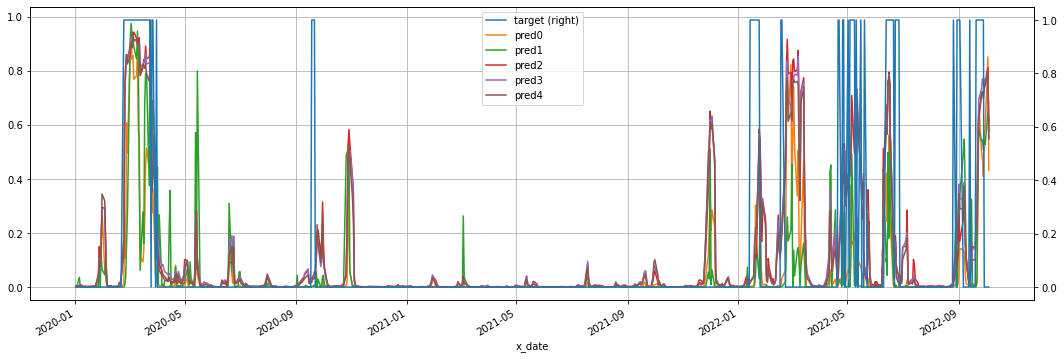

In [16]:
df_pred.plot(figsize=(18, 6), secondary_y=['target'], grid=True)

In [17]:
df_pred['pred_mean']=df_pred[pred_cols].mean(axis=1)
df_pred['pred_mean_label']=((df_pred[pred_cols]>0.5).mean(axis=1)>0.5).astype(int)


<AxesSubplot:xlabel='x_date'>

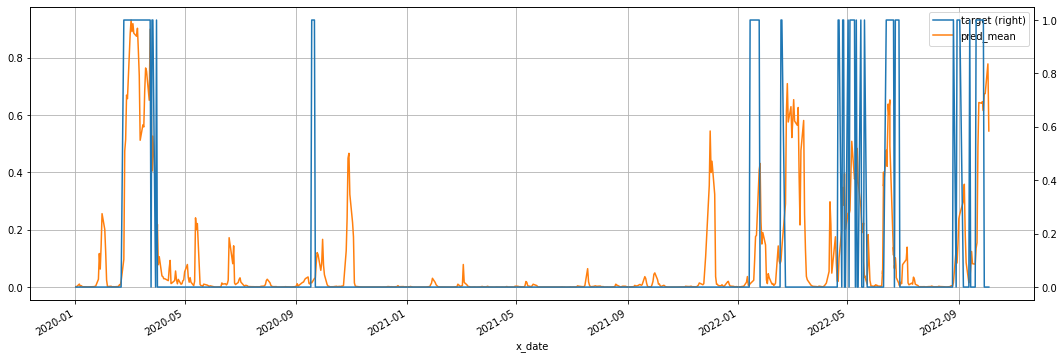

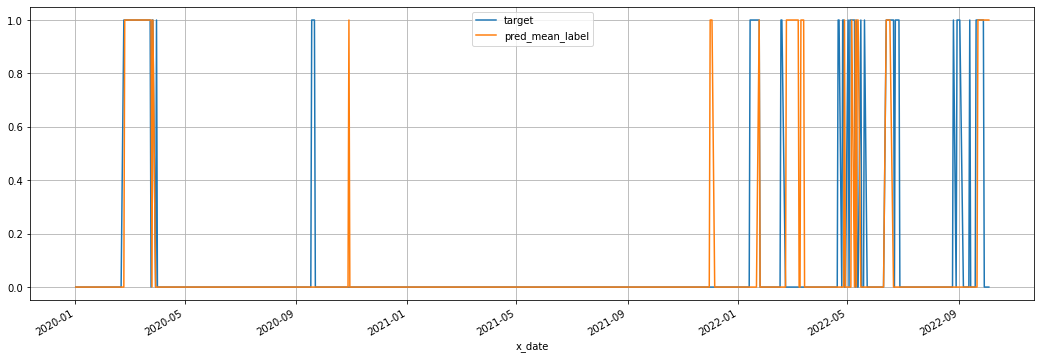

In [18]:
df_pred[['target', 'pred_mean',]].plot(figsize=(18, 6), secondary_y=['target'], grid=True)
df_pred[['target', 'pred_mean_label']].plot(figsize=(18, 6),  grid=True)

In [19]:
df_pred[df_pred.index>'2020-02-15'].head(20)

,target,pred0,pred1,pred2,pred3,pred4,pred_mean,pred_mean_label
x_date,,,,,,,,
2020-02-18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
2020-02-19,0.00,0.00,0.00,0.02,0.01,0.01,0.01,0
2020-02-20,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0
2020-02-21,0.00,0.00,0.00,0.04,0.03,0.03,0.02,0
2020-02-24,1.00,0.01,0.00,0.12,0.18,0.17,0.10,0
2020-02-25,1.00,0.27,0.01,0.70,0.70,0.70,0.47,1
2020-02-26,1.00,0.11,0.03,0.82,0.81,0.80,0.51,1
2020-02-27,1.00,0.61,0.16,0.86,0.86,0.86,0.67,1
2020-02-28,1.00,0.50,0.28,0.84,0.85,0.83,0.66,1


<a id="2.4"></a>

## <left>2.4 Model performance - AUC and Confusion matrix</left>

[back to top](#toc)

In [20]:
from sklearn.metrics import roc_auc_score

In [21]:
for c in pred_cols + ['pred_mean']:
    auc_score = roc_auc_score(df_pred['target'], df_pred[c])
    print(c, f'{auc_score:.3f}')

pred0 0.896
pred1 0.855
pred2 0.921
pred3 0.925
pred4 0.926
pred_mean 0.921


In [22]:
prob_cut = 0.5
tp = ((df_pred['pred_mean']>prob_cut) & (df_pred['target']==1) ).sum() #true positive 
fp = ((df_pred['pred_mean']>prob_cut) & (df_pred['target']==0) ).sum() #false positive
fn = ((df_pred['pred_mean']<=prob_cut) & (df_pred['target']==1) ).sum() #false negative
tn = ((df_pred['pred_mean']<=prob_cut) & (df_pred['target']==0) ).sum() #true negative

cm = pd.DataFrame(data=[[tp, fp, ], [fn, tn,]], 
                  index=['Predict: Crisis', 'Predict: Normal'], 
                  columns=['Actual: Crisis', 'Actual: Normal', ],
                 )
precision = tp/(tp+fp) 
recall = tp/(tp + fn)
#cm

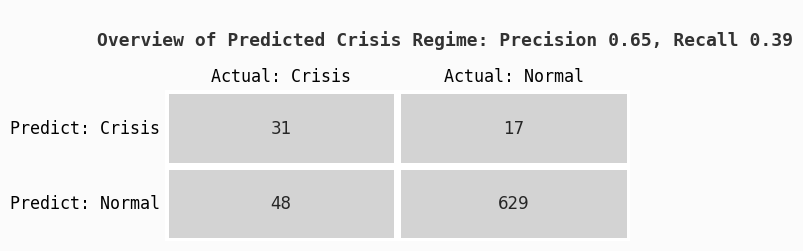

In [23]:
colors = ["lightgray", "lightgray","lightgray",]


background_color = "#fbfbfb"

fig, ax = plt.subplots(1, 1, figsize=(6,2),  dpi=100,facecolor=background_color)


sns.heatmap(cm, cmap=colors,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax,
            yticklabels=cm.index,vmax=500,vmin=0,
            xticklabels=cm.columns,annot_kws={"fontsize":12})
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_facecolor(background_color) 
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontfamily='monospace', fontsize=10)#
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontfamily='monospace', fontsize=10)#
#ax.tick_params(axis=u'both', which=u'both',length=0, )
ax.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
fig.text(.012, 1., f'''
Overview of Predicted Crisis Regime: Precision {precision:.2f}, Recall {recall:.2f}
''', fontfamily='monospace',fontweight='bold',fontsize=13,color='#323232', ha='left')


plt.show()

<a id="3"></a>

# <left>3. Sliding Window with Fixed Length of Training Data</left>

[back to top](#toc)

<a id="3.1"></a>

## <left>3.1 Create Sliding window - fixed length of training data</left>

[back to top](#toc)

In [24]:
kfold_list = []

for yr in [2020, 2022]:
    train_loc = (train_df.index<f'{yr-1}-12-01') & (train_df.index>=f'{yr-15}-12-01') 
    test_loc = (df.index>=f'{yr}-01-01') & (df.index<f'{yr+2}-01-01')
    kfold_list.append([train_df.loc[train_loc, final_feats], train_df.loc[train_loc, 'target'],
                       df.loc[test_loc, final_feats], df.loc[test_loc, ['target']],
                      ]
                     )
    
for i, (a, b, c, d) in enumerate(kfold_list):
    print(i+1, a.shape, b.shape, c.shape, d.shape, a.index.min(), a.index.max(), c.index.min(), c.index.max())

1 (3523, 127) (3523,) (505, 127) (505, 1) 2005-12-01 00:00:00 2019-11-29 00:00:00 2020-01-02 00:00:00 2021-12-31 00:00:00
2 (3020, 127) (3020,) (220, 127) (220, 1) 2007-12-03 00:00:00 2019-11-29 00:00:00 2022-01-03 00:00:00 2022-10-04 00:00:00




<a id="3.2"></a>

## <left>3.2 Predict testing data with models trained on train data</left>

[back to top](#toc)



In [25]:

score_dfs = []
preds_list = []
pred_cols = []
models_dict = {}
for iter_i, params in iter_dict.items():
    params = copy.deepcopy(params)
    print(params)
    
    num_boost_round = params['num_boost_round']
    del params['num_boost_round']

    scores_i = []
    preds_list_i = []
    models_list_i = []
    for j, (X_train, y_train, X_test, y_test) in enumerate(kfold_list):
        y_preds, df_scores, i_model = get_tree_preds(X_train, y_train, X_test, params=params,
                                                       num_round=num_boost_round, 
                                                       cust_eval=None)
        df_pred_i = y_test.copy(deep=True)
        df_pred_i[f'pred{iter_i}'] = y_preds
        scores_i.append(df_scores)
        preds_list_i.append(df_pred_i)
        models_list_i.append(i_model)
    
    models_dict[iter_i] = models_list_i
        
    
    df_pred = pd.concat(preds_list_i, axis=0)
                 
    pred_cols.append(f'pred{iter_i}')
    preds_list.append(df_pred)

{'bagging_fraction': 0.615, 'bagging_freq': 17, 'boosting': 'gbdt', 'feature_fraction': 0.5, 'lambda_l1': 1.918, 'lambda_l2': 0.938, 'learning_rate': 0.1, 'max_bin': 492, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 70, 'min_gain_to_split': 0.42, 'min_sum_hessian_in_leaf': 0.22, 'num_boost_round': 970, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
{'bagging_fraction': 0.515, 'bagging_freq': 8, 'boosting': 'gbdt', 'feature_fraction': 0.4, 'lambda_l1': 0.377, 'lambda_l2': 0.762, 'learning_rate': 0.34, 'max_bin': 357, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 100, 'min_gain_to_split': 0.36, 'min_sum_hessian_in_leaf': 0.62, 'num_boost_round': 680, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
{'bagging_fraction': 0.485, 'bagging_freq': 9, 'boosting': 'gbdt', 'feature_fraction': 0.6, 'lambda_l1': 1.637, 'lambda_l2': 0.637, 'learning_rate': 0.02, 'max_bin': 468, 'max_depth': 1, 'metric': 'auc', 'min_data_in_leaf': 95, 'min_gain_to_split': 0.31, 'min

<a id="3.3"></a>

## <left>3.3 Model performance - Ground truth and Predictions</left>

[back to top](#toc)

In [26]:
t = pd.concat(preds_list, axis=1)
df_pred = t.iloc[:, :1].copy(deep=True)
df_pred[pred_cols] = t[pred_cols]
df_pred.head(5)

,target,pred0,pred1,pred2,pred3,pred4
x_date,,,,,,
2020-01-02,0.00,0.00,0.00,0.00,0.00,0.00
2020-01-03,0.00,0.00,0.00,0.00,0.00,0.00
2020-01-06,0.00,0.00,0.00,0.01,0.00,0.00
2020-01-07,0.00,0.00,0.00,0.00,0.00,0.00
2020-01-08,0.00,0.00,0.00,0.01,0.01,0.00


<AxesSubplot:xlabel='x_date'>

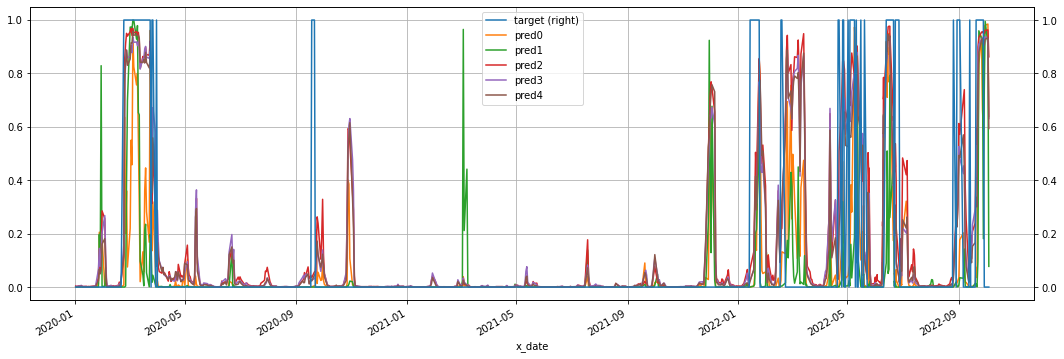

In [27]:
df_pred.plot(figsize=(18, 6), secondary_y=['target'], grid=True)

In [28]:
df_pred['pred_mean']=df_pred[pred_cols].mean(axis=1)
df_pred['pred_mean_label']=((df_pred[pred_cols]>0.5).mean(axis=1)>0.5).astype(int)


<AxesSubplot:xlabel='x_date'>

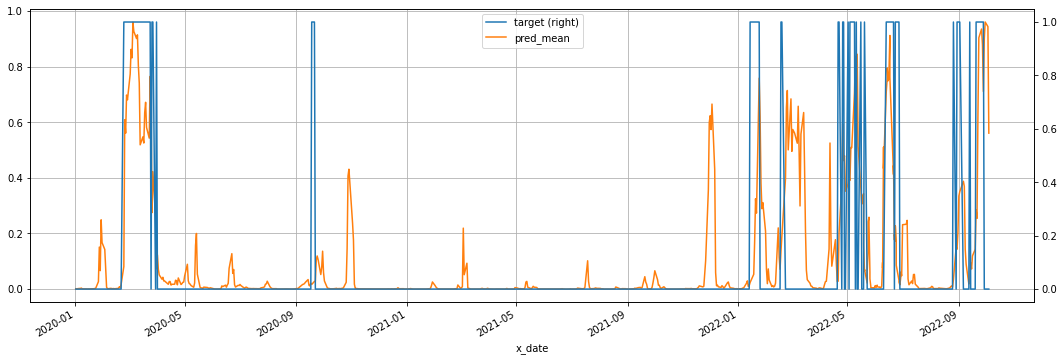

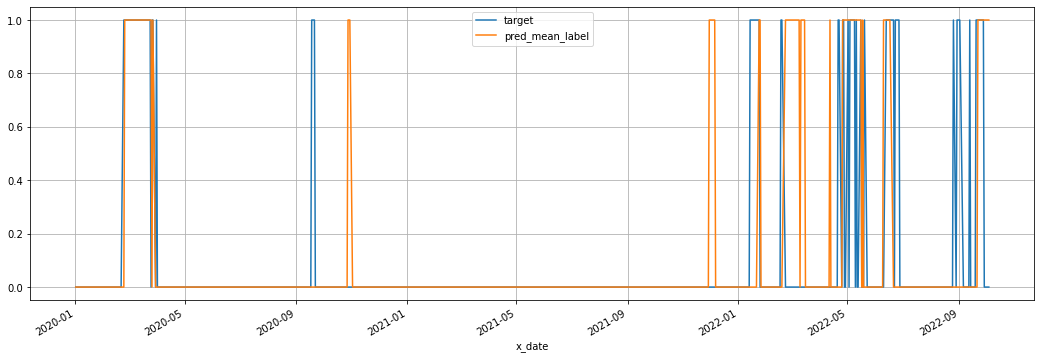

In [29]:
df_pred[['target', 'pred_mean',]].plot(figsize=(18, 6), secondary_y=['target'], grid=True)
df_pred[['target', 'pred_mean_label']].plot(figsize=(18, 6),  grid=True)

In [30]:
df_pred[df_pred.index>'2020-02-15'].head(20)

,target,pred0,pred1,pred2,pred3,pred4,pred_mean,pred_mean_label
x_date,,,,,,,,
2020-02-18,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0
2020-02-19,0.00,0.00,0.00,0.02,0.01,0.01,0.01,0
2020-02-20,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0
2020-02-21,0.00,0.00,0.00,0.02,0.03,0.03,0.02,0
2020-02-24,1.00,0.01,0.00,0.11,0.16,0.13,0.08,0
2020-02-25,1.00,0.64,0.00,0.86,0.76,0.79,0.61,1
2020-02-26,1.00,0.20,0.00,0.91,0.84,0.84,0.56,1
2020-02-27,1.00,0.36,0.40,0.95,0.89,0.89,0.70,1
2020-02-28,1.00,0.08,0.70,0.94,0.86,0.83,0.68,1


<a id="3.4"></a>

## <left>3.4 Model performance - AUC and Confusion matrix </left>

[back to top](#toc)

In [31]:
for c in pred_cols + ['pred_mean']:
    auc_score = roc_auc_score(df_pred['target'], df_pred[c])
    print(c, f'{auc_score:.3f}')

pred0 0.905
pred1 0.873
pred2 0.940
pred3 0.934
pred4 0.934
pred_mean 0.933


In [32]:
prob_cut = 0.5
tp = ((df_pred['pred_mean']>prob_cut) & (df_pred['target']==1) ).sum() #true positive 
fp = ((df_pred['pred_mean']>prob_cut) & (df_pred['target']==0) ).sum() #false positive
fn = ((df_pred['pred_mean']<=prob_cut) & (df_pred['target']==1) ).sum() #false negative
tn = ((df_pred['pred_mean']<=prob_cut) & (df_pred['target']==0) ).sum() #true negative

cm = pd.DataFrame(data=[[tp, fp, ], [fn, tn,]], 
                  index=['Predict: Crisis', 'Predict: Normal'], 
                  columns=['Actual: Crisis', 'Actual: Normal', ],
                 )
precision = tp/(tp+fp) 
recall = tp/(tp + fn)
#cm

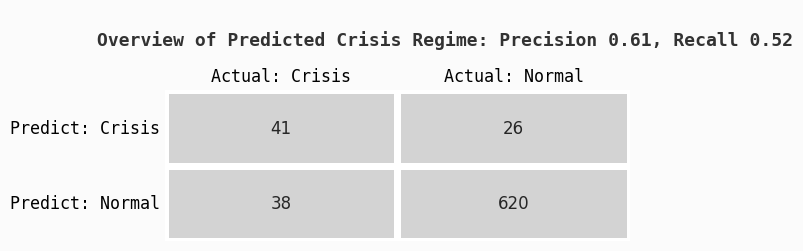

In [33]:
colors = ["lightgray", "lightgray","lightgray",]


background_color = "#fbfbfb"

fig, ax = plt.subplots(1, 1, figsize=(6,2),  dpi=100,facecolor=background_color)


sns.heatmap(cm, cmap=colors,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax,
            yticklabels=cm.index,vmax=500,vmin=0,
            xticklabels=cm.columns,annot_kws={"fontsize":12})
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_facecolor(background_color) 
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontfamily='monospace', fontsize=10)#
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontfamily='monospace', fontsize=10)#
#ax.tick_params(axis=u'both', which=u'both',length=0, )
ax.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
fig.text(.012, 1., f'''
Overview of Predicted Crisis Regime: Precision {precision:.2f}, Recall {recall:.2f}
''', fontfamily='monospace',fontweight='bold',fontsize=13,color='#323232', ha='left')


plt.show()

<a id="4"></a>

# <left>4. Model Interpretation and Explanation with SHAP</left>

[back to top](#toc)






<a id="4.1"></a>

## <left>4.1 SHAP (SHapley Additive exPlanations)</left>

[back to top](#toc)

In [34]:
import shap

2022-10-08 17:59:17.840475: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


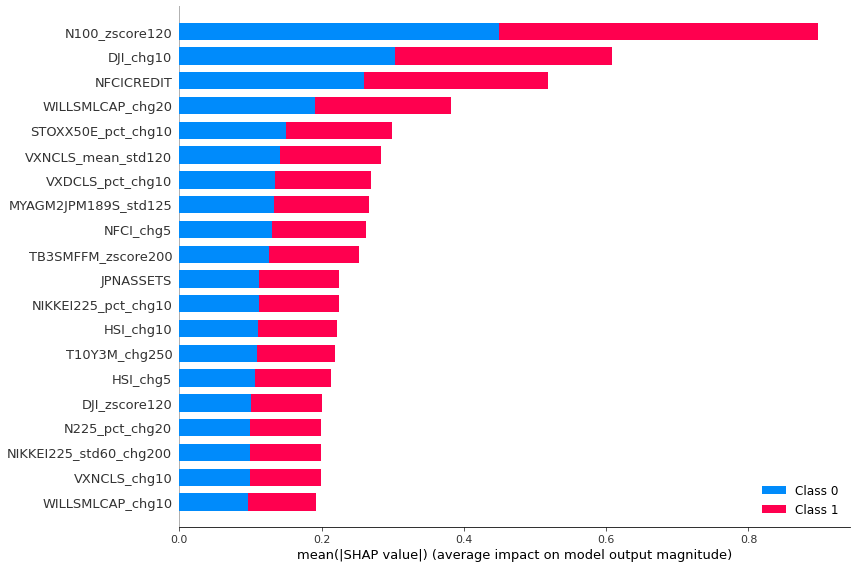

In [35]:
#only look at iter_i=3
X_test = kfold_list[0][-2]
for iter_i, v in models_dict.items():
    if iter_i != 3:
        continue
    tree_model = v[0]
    explainer = shap.TreeExplainer(tree_model, num_iteration=tree_model.best_iteration)
    # explainer = shap.TreeExplainer(tree_model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_size=(12, 8), )

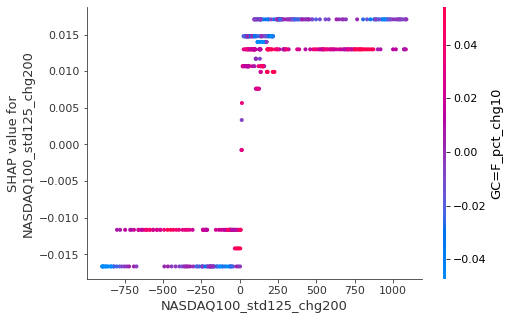

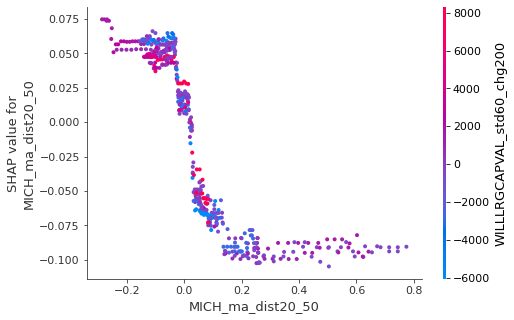

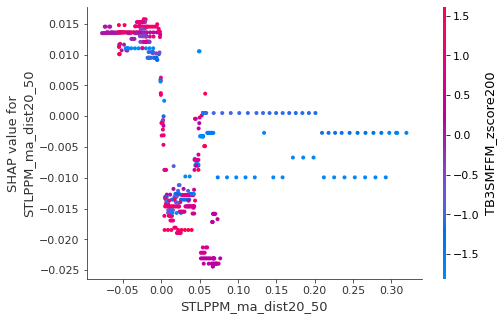

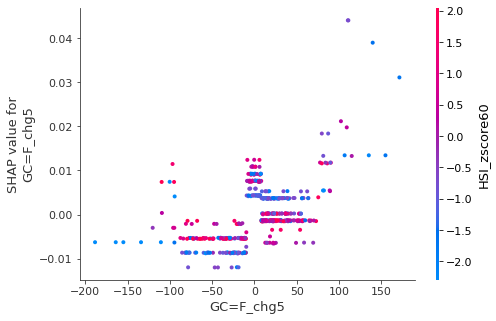

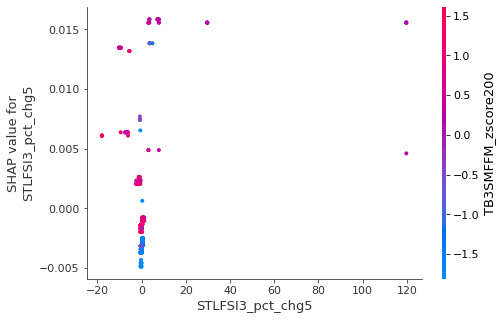

In [36]:
for iter_i, v in models_dict.items():
    if iter_i != 3:
        continue
    tree_model = v[0]
    explainer = shap.TreeExplainer(tree_model, num_iteration=tree_model.best_iteration)
    shap_values = explainer.shap_values(X_test)
    

    for name in X_test.columns[:5]:
        shap.dependence_plot(name, shap_values[1], X_test, )
        
    

In [37]:

expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")



Explainer expected value: -4.474512335352596


In [38]:
tp_sample = df_pred[(df_pred['target']==1) & (df_pred['pred_mean']>0.5)].index[0]
tn_sample = df_pred[(df_pred['target']==0) & (df_pred['pred_mean']<0.2)].index[0]
tp_sample, tn_sample

(Timestamp('2020-02-25 00:00:00'), Timestamp('2020-01-02 00:00:00'))


<a id="4.2"></a>

## <left>4.2 True Positive Example: Model correctly predicted imminent crisis regime </left>

[back to top](#toc)



In [39]:
features = X_test.loc[X_test.index==tp_sample] #examine one date. this is a data frame
shap_values = explainer.shap_values(features)[1] #shap values for the row
shap_interaction_values = explainer.shap_interaction_values(features)
    
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

In [40]:
dis = [f'{a} ({b:.03f})' for a, b in zip(features.columns, features.values[0].round(3))]
shap_bar = pd.DataFrame(data={'feat': dis, 'shap': shap_values[0]})

In [41]:
x_ = shap_bar['shap']
shap_bar['shap_z'] = (x_ - x_.mean())/x_.std()
shap_bar['colors'] = ['red' if x_ > 0 else 'green' for x_ in shap_bar['shap_z']]
shap_bar = shap_bar[shap_bar['shap_z'].abs()>0.4]
shap_bar.sort_values('shap_z', inplace=True, ascending=False)
shap_bar.reset_index(inplace=True)


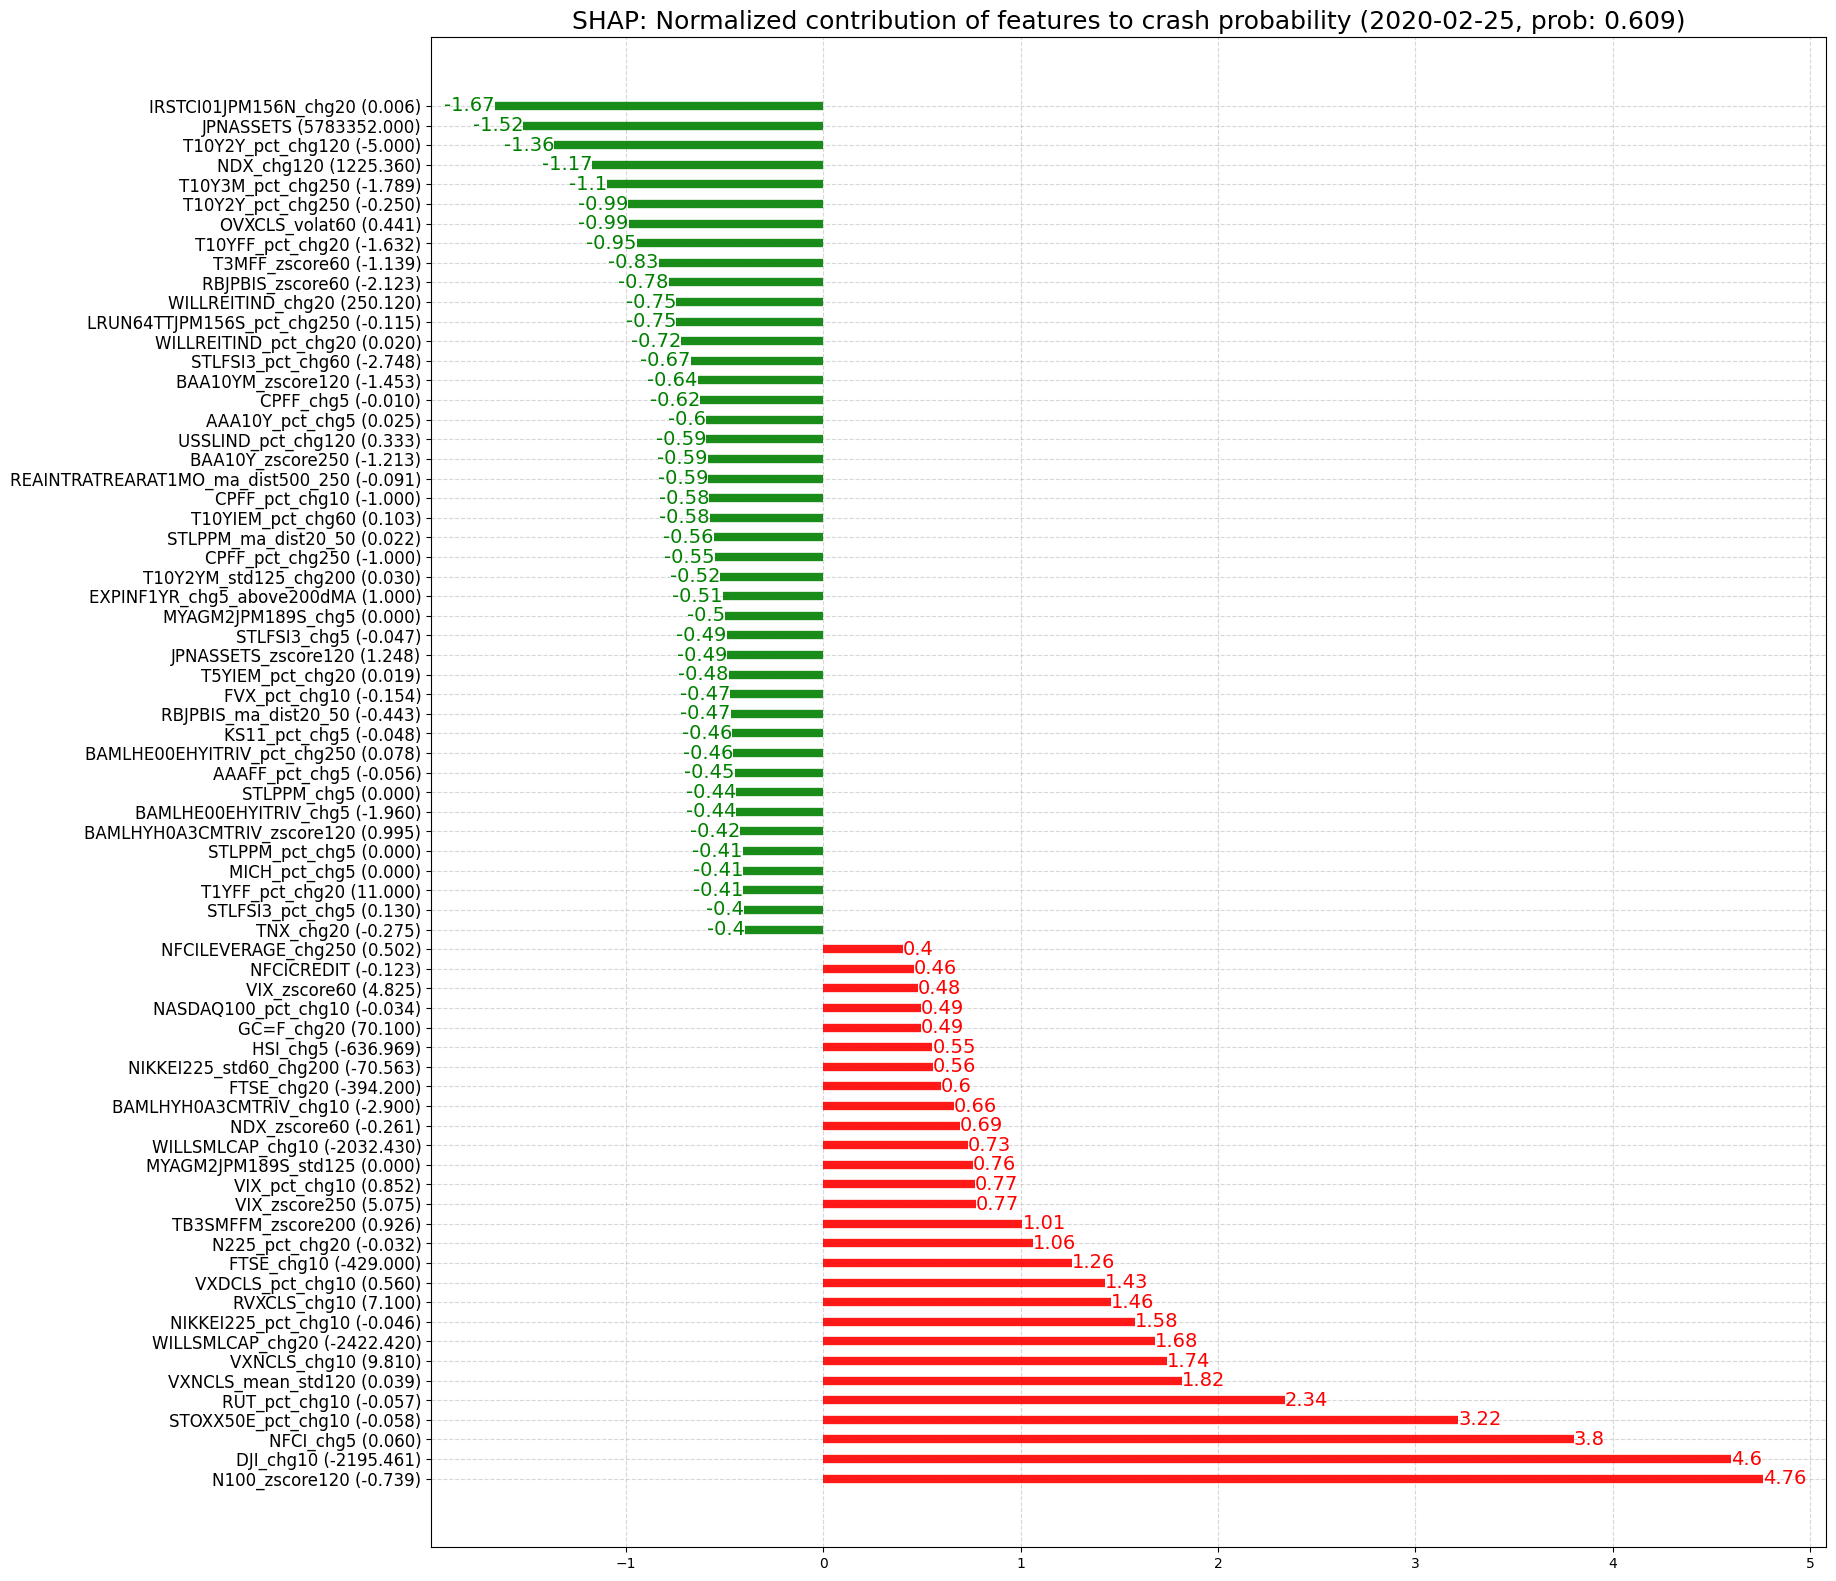

In [42]:
# Draw plot
plt.figure(figsize=(18,20), dpi= 100)
plt.hlines(y=shap_bar.index, xmin=0, xmax=shap_bar.shap_z, color=shap_bar.colors, alpha=0.9, linewidth=6)
for x, y, tex in zip(shap_bar.shap_z, shap_bar.index, shap_bar.shap_z):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left',
                 verticalalignment='center', fontdict={'color':'red' if x > 0 else 'green', 'size':14})

# Decorations
plt.yticks(shap_bar.index, shap_bar.feat, fontsize=12)
plt.title(f"SHAP: Normalized contribution of features to crash probability ({tp_sample.strftime('%Y-%m-%d')}, prob: {df_pred.loc[tp_sample]['pred_mean']:.03f})", 
          fontdict={'size':18})
plt.grid(linestyle='--', alpha=0.5)
# plt.xlim(-2.5, 2.5)
plt.show()



<a id="4.3"></a>

## <left>4.3 True Negative Example: Model correctly predicted normal regime  </left>

[back to top](#toc)


In [43]:
features = X_test.loc[X_test.index==tn_sample] #examine one date. this is a data frame
shap_values = explainer.shap_values(features)[1] #shap values for the row
shap_interaction_values = explainer.shap_interaction_values(features)
    
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

In [44]:
dis = [f'{a} ({b:.03f})' for a, b in zip(features.columns, features.values[0].round(3))]
shap_bar = pd.DataFrame(data={'feat': dis, 'shap': shap_values[0]})

In [45]:
x_ = shap_bar['shap']
shap_bar['shap_z'] = (x_ - x_.mean())/x_.std()
shap_bar['colors'] = ['red' if x_ > 0 else 'green' for x_ in shap_bar['shap_z']]
shap_bar = shap_bar[shap_bar['shap_z'].abs()>0.4]
shap_bar.sort_values('shap_z', inplace=True, ascending=False)
shap_bar.reset_index(inplace=True)


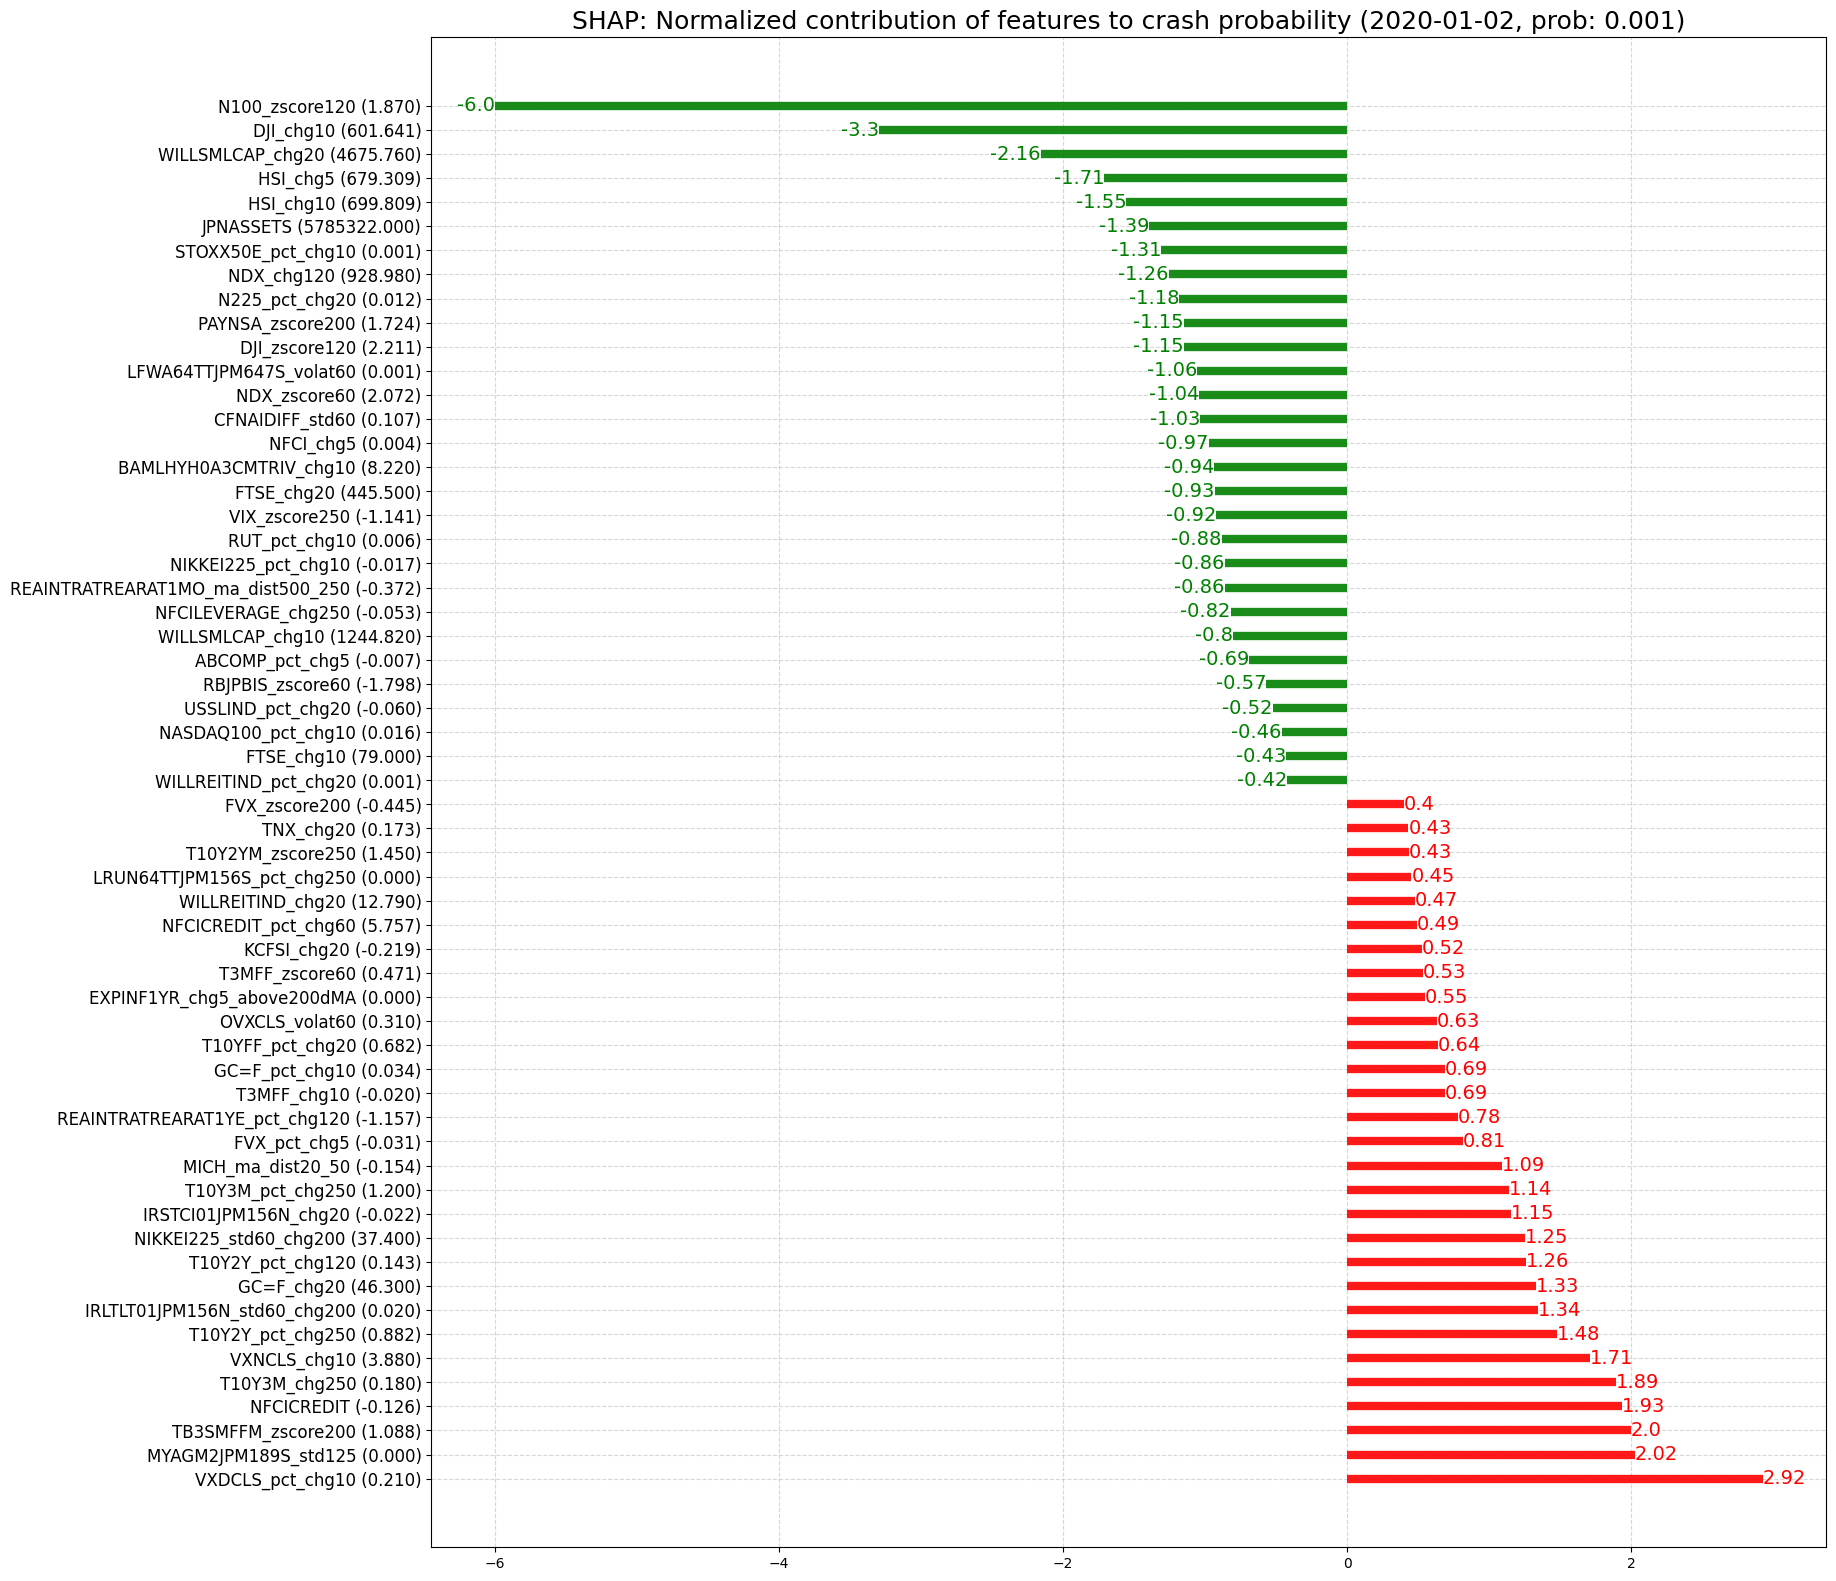

In [46]:
# Draw plot
plt.figure(figsize=(18,20), dpi= 100)
plt.hlines(y=shap_bar.index, xmin=0, xmax=shap_bar.shap_z, color=shap_bar.colors, alpha=0.9, linewidth=6)
for x, y, tex in zip(shap_bar.shap_z, shap_bar.index, shap_bar.shap_z):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left',
                 verticalalignment='center', fontdict={'color':'red' if x > 0 else 'green', 'size':14})

# Decorations
plt.yticks(shap_bar.index, shap_bar.feat, fontsize=12)
plt.title(f"SHAP: Normalized contribution of features to crash probability ({tn_sample.strftime('%Y-%m-%d')}, prob: {df_pred.loc[tn_sample]['pred_mean']:.03f})", 
          fontdict={'size':18})
plt.grid(linestyle='--', alpha=0.5)
# plt.xlim(-2.5, 2.5)
plt.show()



<a id="4.4"></a>

## <left>4.4 Visualize the Trees </left>

[back to top](#toc)



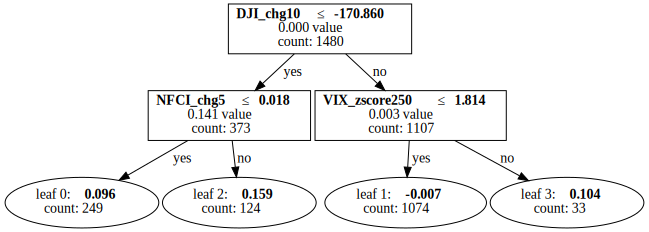

In [47]:
#https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_lightgbm_visualisations.ipynb
lgb.create_tree_digraph(tree_model, tree_index=1,  orientation = "vertical", show_info=['internal_count', 'leaf_count', 'internal_value'])

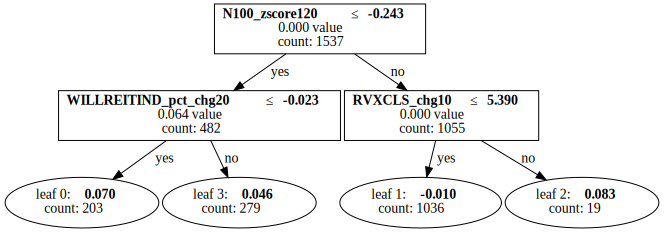

In [48]:

lgb.create_tree_digraph(tree_model, tree_index=10,  orientation = "vertical", show_info=['internal_count', 'leaf_count', 'internal_value'])

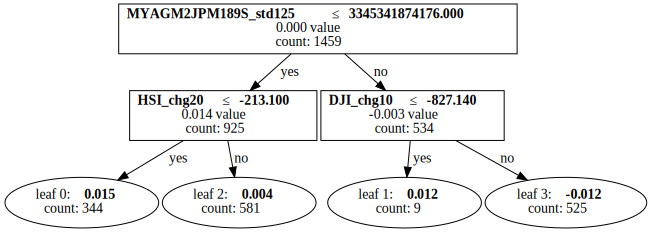

In [49]:
lgb.create_tree_digraph(tree_model, tree_index=100,  orientation = "vertical", show_info=['internal_count', 'leaf_count', 'internal_value'])